## Bibliotecas




In [50]:
import datetime
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import regularizers
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau, TensorBoard)
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.nn import softmax

## Dataset

In [32]:
train_dir = 'PATH'
test_dir = 'PATH'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


## Conjuntos de Treino e Teste

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   validation_split = 0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset = "training")

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.2)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [34]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Definindo o modelo

In [35]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, epsilon=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [36]:
fernet = get_model((row,col,1), classes)
fernet.summary()

C:\Users\flags\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,116,743 (122.52 MB)

 Trainable params: 32,116,103 (122.51 MB)

 Non-trainable params: 640 (2.50 KB)

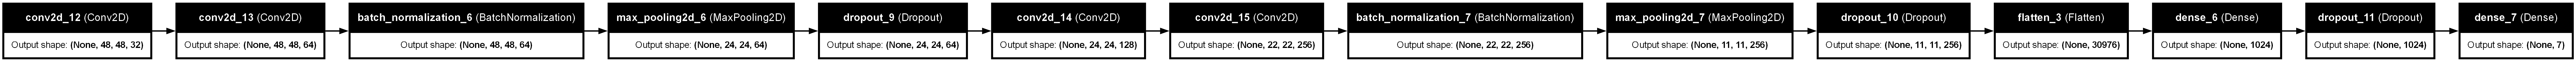

In [37]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, rankdir='LR', show_layer_names=True)

In [38]:
chk_path = 'ferNet.keras'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='max',
                             monitor='val_accuracy')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Treino

In [39]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60


C:\Users\flags\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.2420 - loss: 5.0474
Epoch 1: val_accuracy improved from -inf to 0.01562, saving model to ferNet.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 173s 473ms/step - accuracy: 0.2421 - loss: 5.0455 - val_accuracy: 0.0156 - val_loss: 8.9467 - learning_rate: 1.0000e-04
Epoch 2/60
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:23 569ms/step - accuracy: 0.2344 - loss: 3.9204
Epoch 2: val_accuracy did not improve from 0.01562
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step - accuracy: 0.2344 - loss: 1.9657 - val_accuracy: 0.0000e+00 - val_loss: 4.2847 - learning_rate: 1.0000e-04
Epoch 3/60


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.3194 - loss: 3.7525
Epoch 3: val_accuracy improved from 0.01562 to 0.38991, saving model to ferNet.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 213s 590ms/step - accuracy: 0.3194 - loss: 3.7521 - val_accuracy: 0.3899 - val_loss: 3.3259 - learning_rate: 1.0000e-04
Epoch 4/60
  1/358 ━━━━━━━━━━━━━━━━━━━━ 2:59 503ms/step - accuracy: 0.2344 - loss: 3.4865
Epoch 4: val_accuracy did not improve from 0.38991
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.2344 - loss: 1.7481 - val_accuracy: 0.3750 - val_loss: 1.6159 - learning_rate: 1.0000e-04
Epoch 5/60
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.3549 - loss: 3.2624
Epoch 5: val_accuracy improved from 0.38991 to 0.39560, saving model to ferNet.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 182s 504ms/step - accuracy: 0.3549 - loss: 3.2621 - val_accuracy: 0.3956 - val_loss: 2.8816 - learning_rate: 1.0000e-04
Epoch 6/60
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:50 645ms/step - accuracy: 0.3906 - lo

In [40]:
fernet.save_weights('fernet_bestweight.weights.h5')

## Grafico de precisão

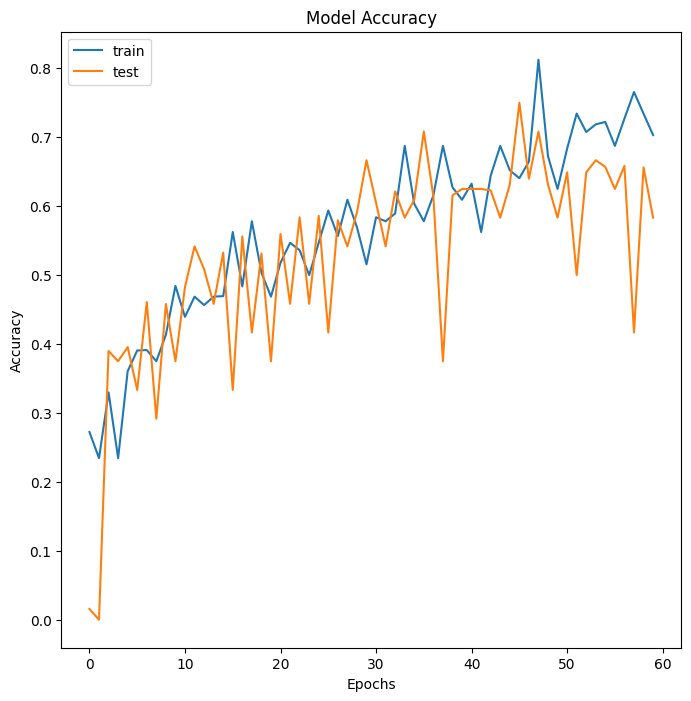

In [41]:
plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

## Avaliação do modelo

In [42]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 44s 122ms/step - accuracy: 0.7997 - loss: 0.6875
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6558 - loss: 1.0487
final train accuracy = 79.78 , validation accuracy = 65.57


## Matriz de confusão e classificação do conjunto de testes

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step
Confusion Matrix
[[28  0 30 43 44 29 17]
 [ 4  0  4  5  2  4  3]
 [34  2 18 54 38 35 23]
 [48  1 37 91 75 58 44]
 [42  1 24 56 50 41 32]
 [36  2 25 62 40 49 35]
 [23  1 20 48 37 20 17]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.15      0.14       191
     disgust       0.00      0.00      0.00        22
        fear       0.11      0.09      0.10       204
       happy       0.25      0.26      0.26       354
     neutral       0.17      0.20      0.19       246
         sad       0.21      0.20      0.20       249
    surprise       0.10      0.10      0.10       166

    accuracy                           0.18      1432
   macro avg       0.14      0.14      0.14      1432
weighted avg       0.17      0.18      0.17      1432



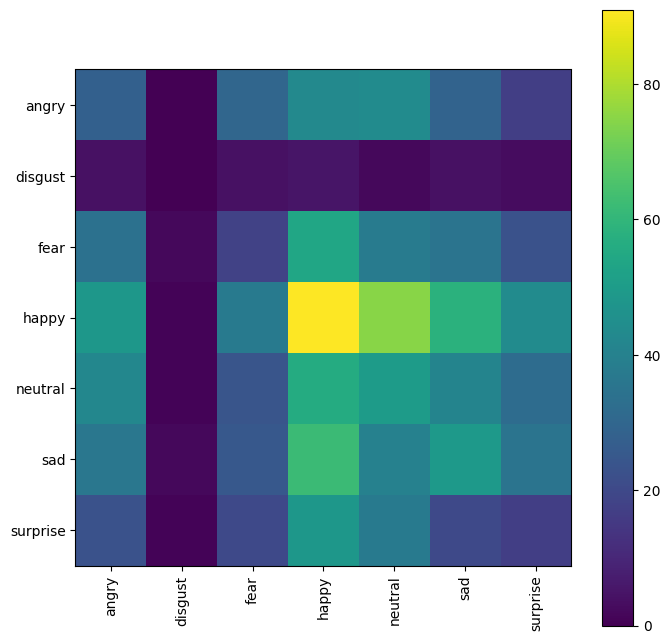

In [43]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Visualização dos resultados

In [44]:
classnames = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

(48, 48)


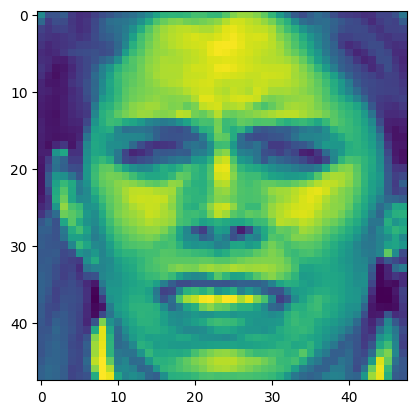

In [45]:
imagem2 = load_img("PATH",target_size = (48,48),color_mode = "grayscale")
imagem = np.array(imagem2)
plt.imshow(imagem)
print(imagem.shape)

In [ ]:
imagem = np.expand_dims(imagem2,axis = 0) #makes image shape (1,48,48)
imagem = imagem.reshape(1,48,48,1)
prediction = fernet.predict(imagem)
result=np.argmax(prediction,axis=1)
result = list(prediction[0])
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0. 0. 0. 1. 0. 0. 0.]]


In [47]:
img_index = result.index(max(result))
print(classnames[img_index])

happy


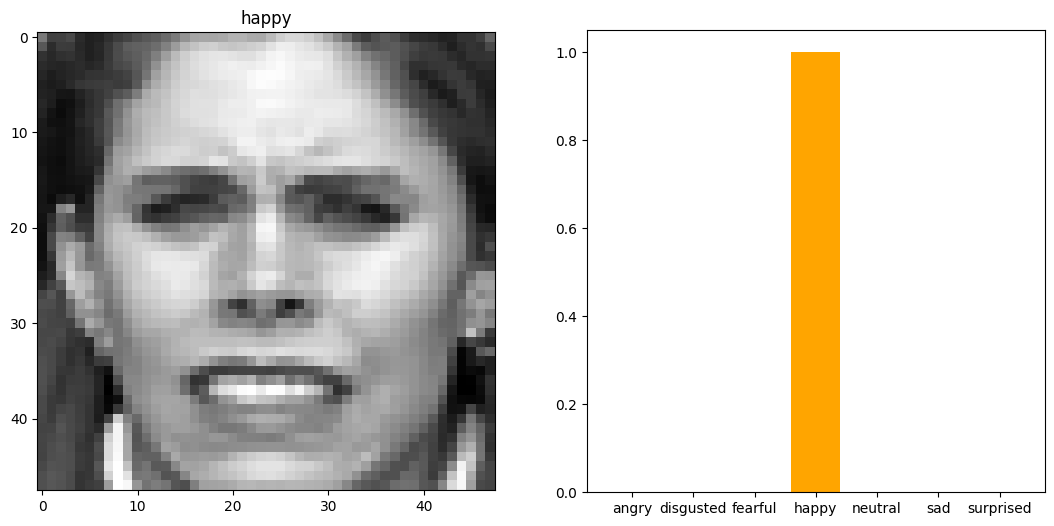

In [48]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.imshow(imagem2, cmap='gray')
plt.title(classnames[img_index])

plt.subplot(1,2,2)
plt.bar(classnames, prediction[0], color = 'orange')
plt.show()